# Imports

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, confusion_matrix, classification_report
# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
titles = pd.read_csv('../data/processed_titles.csv')
titles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4430 entries, 0 to 4429
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       4430 non-null   int64 
 1   title            4430 non-null   object
 2   subreddit        4430 non-null   object
 3   processed_title  4404 non-null   object
dtypes: int64(1), object(3)
memory usage: 138.6+ KB


In [4]:
titles.dropna(inplace = True)

# TrainTestSpliting

In [6]:
# Creating a binarized target column musicians:0, DJs:1
titles['labels'] = titles['subreddit'].map({'musicians':0, 'DJs':1})

In [7]:
# Creating target(y) and predictor(X) variables
ytitles = titles['labels']
Xtitles = titles['processed_title']

In [8]:
ytitles.value_counts(normalize = True)

labels
1    0.518392
0    0.481608
Name: proportion, dtype: float64

In [9]:
# Split the data into the training and testing sets.
Xtitles_train, Xtitles_test, ytitles_train, ytitles_test = train_test_split(Xtitles,
                                                    ytitles,
                                                    test_size=0.33,
                                                    stratify=ytitles,
                                                    random_state=42)

In [88]:
# checking the balance of classes in our data
print(ytitles_train.value_counts())
print(ytitles_train.value_counts(normalize = True))
print(ytitles_test.value_counts())
print(ytitles_test.value_counts(normalize = True))

labels
1    1529
0    1421
Name: count, dtype: int64
labels
1    0.518305
0    0.481695
Name: proportion, dtype: float64
labels
1    754
0    700
Name: count, dtype: int64
labels
1    0.518569
0    0.481431
Name: proportion, dtype: float64


# Modelling titles from r/DJs and r/musicians: Logistic Regression

**Count Vectorizer and Logistic Regression: Gridsearching over the Pipeline**

In [58]:
titles_pipeline_1 = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

In [59]:
pipe_params = {
    'cvec__max_features': [2000, 3000, 4000], # How many words the average person has in their lexicon 
    'cvec__stop_words': [None, 'english'], 
    'cvec__min_df': [2, 4], # 
    'cvec__max_df': [0.99, 0.95, 0.8], 
    'lr__penalty': ['l1', 'l2', 'elasticnet', None],
    'lr__solver': ['liblinear']
}

In [61]:
gs_1 = GridSearchCV(titles_pipeline_1,
                 pipe_params,
                 n_jobs = -1)

gs.fit(Xtitles_train, ytitles_train)
print(gs.best_score_)
gs.best_params_

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

0.8196610169491525


{'cvec__max_df': 0.99,
 'cvec__max_features': 2000,
 'cvec__min_df': 2,
 'cvec__stop_words': 'english',
 'lr__penalty': 'l2'}

## Model Evaluation: Logistic Regression

In [62]:
titles_predictions_1 = gs.predict(Xtitles_test)

In [63]:
#Accuracy 
print(gs.score(Xtitles_train, ytitles_train))
print(gs.score(Xtitles_test, ytitles_test))

#.1 or more in general tends to be overfit. But consider the baseline score, if its tonnes better, then dont really matter. 

0.940677966101695
0.8349381017881705


In [64]:
# Misclassification rate 
print(1 - gs.score(Xtitles_train, ytitles_train))
print(1 - gs.score(Xtitles_test, ytitles_test))

0.05932203389830504
0.16506189821182948


In [65]:
#Calculating Specificity
#Confusion Matrix 
tn, fp, fn, tp = confusion_matrix(ytitles_test, titles_predictions).ravel()

specificity = tn / (tn + fp)
print(f'Our model specificity: {specificity}')

Our model specificity: 0.8071428571428572


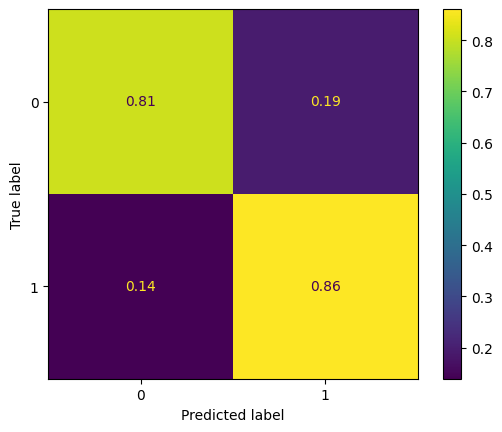

In [84]:
ConfusionMatrixDisplay.from_estimator(gs, Xtitles_test, ytitles_test, normalize = 'true');

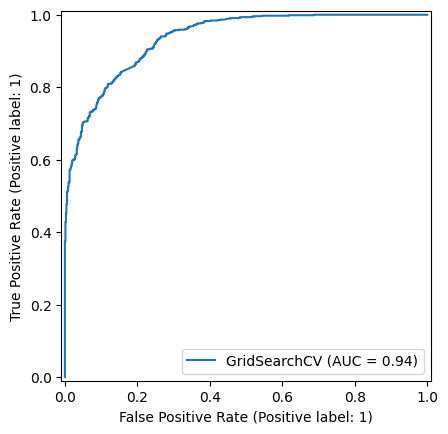

In [67]:
RocCurveDisplay.from_estimator(gs, Xtitles_test, ytitles_test);
# how is the model doing at different classification thresholds. the closer to a right angle the better the model is?

In [90]:
classification_report(ytitles_test, titles_predictions)

'              precision    recall  f1-score   support\n\n           0       0.84      0.81      0.82       700\n           1       0.83      0.86      0.84       754\n\n    accuracy                           0.83      1454\n   macro avg       0.84      0.83      0.83      1454\nweighted avg       0.84      0.83      0.83      1454\n'

In [91]:
report = classification_report(ytitles_test, titles_predictions, output_dict=True)
df = pd.DataFrame(report).transpose()
print(df)

              precision    recall  f1-score      support
0              0.843284  0.807143  0.824818   700.000000
1              0.827806  0.860743  0.843953   754.000000
accuracy       0.834938  0.834938  0.834938     0.834938
macro avg      0.835545  0.833943  0.834385  1454.000000
weighted avg   0.835257  0.834938  0.834741  1454.000000


In [69]:
# Checking recall, good for understanding how model deals with false negatives
recall_1 = tp / (tp + fn)

print(f'Recall: {recall_1}')

Recall: 0.8607427055702918


# Modelling titles from r/DJs and r/musicians: Multinomial Naive Bayes

[Source](https://deepnote.com/app/emmanuelmicron/Spam-Detection-using-Multinomial-Naive-Bayes-Model-a9a6bc89-e723-4c32-8679-86a5ff1978f3#:~:text=The%20multinomial%20Naive%20Bayes%20classifier,as%20they%20give%20good%20results.)

In [70]:
titles_pipeline_2 = Pipeline([
    ('cvec', CountVectorizer()),
    ('NB', MultinomialNB())
])

In [71]:
pipe_params_2 = {
    'cvec__max_features': [2000, 3000, 4000], # How many words the average person has in their lexicon 
    'cvec__stop_words': [None, 'english'], 
    'cvec__min_df': [2, 4], # 
    'cvec__max_df': [0.99, 0.95, 0.8], 
    'NB__alpha': [0.1, 0.5, 1.0]
}

In [72]:
gs_2 = GridSearchCV(titles_pipeline_2,
                 pipe_params_2,
                 n_jobs = -1)

gs_2.fit(Xtitles_train, ytitles_train)
print(gs_2.best_score_)
gs_2.best_params_

0.8233898305084745


{'NB__alpha': 1.0,
 'cvec__max_df': 0.99,
 'cvec__max_features': 2000,
 'cvec__min_df': 2,
 'cvec__stop_words': 'english'}

## Model Evaluation: Multinomial Naive Bayes

In [73]:
titles_predictions_2 = gs_2.predict(Xtitles_test)

In [74]:
#Accuracy 
print(gs_2.score(Xtitles_train, ytitles_train))
print(gs_2.score(Xtitles_test, ytitles_test))

#.1 or more in general tends to be overfit. But consider the baseline score, if its tonnes better, then dont really matter. 

0.8986440677966102
0.8459422283356258


In [75]:
# Misclassification rate 
print(1 - gs_2.score(Xtitles_train, ytitles_train))
print(1 - gs_2.score(Xtitles_test, ytitles_test))

0.10135593220338979
0.15405777166437418


In [76]:
#Calculating Specificity
#Confusion Matrix 
tn, fp, fn, tp = confusion_matrix(ytitles_test, titles_predictions_2).ravel()

specificity_2 = tn / (tn + fp)
print(f'Our model specificity: {specificity_2}')

Our model specificity: 0.8257142857142857


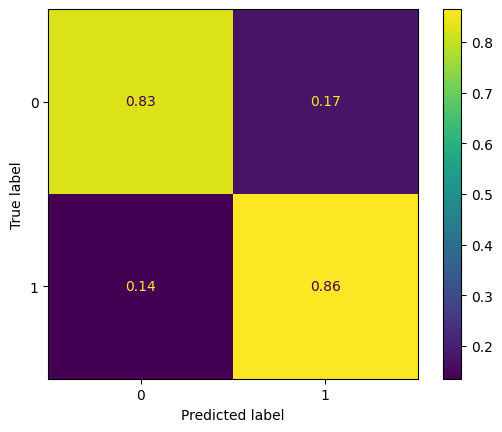

In [85]:
ConfusionMatrixDisplay.from_estimator(gs_2, Xtitles_test, ytitles_test, normalize = 'true');

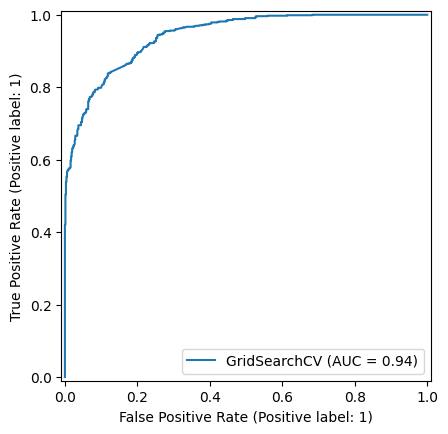

In [78]:
RocCurveDisplay.from_estimator(gs_2, Xtitles_test, ytitles_test);
# how is the model doing at different classification thresholds. the closer to a right angle the better the model is "Explanation from Hank Butler". 

In [93]:
classification_report(ytitles_test, titles_predictions_2)
report2 = classification_report(ytitles_test, titles_predictions_2, output_dict=True)
df2 = pd.DataFrame(report).transpose()
print(df2)

              precision    recall  f1-score      support
0              0.843284  0.807143  0.824818   700.000000
1              0.827806  0.860743  0.843953   754.000000
accuracy       0.834938  0.834938  0.834938     0.834938
macro avg      0.835545  0.833943  0.834385  1454.000000
weighted avg   0.835257  0.834938  0.834741  1454.000000


In [80]:
# Checking recall, good for understanding how model deals with false negatives
recall_2 = tp / (tp + fn)

print(f'Recall: {recall_2}')

Recall: 0.8647214854111406


# Evaluation Summary 

Based on the accuracy scores of the Logistic Regression, 94% of the instances in the training set, and, 83% of the instances in the testing set were classified correctly (which indicates some overfitting of the model to the training set). Similarly, the multinomial naive bayes model achieved a training accuracy of 90% and a testing accuracy of 85% (less overfitting than Logsitic Regression model). Both of these models beat the baseline accuracy of 0.52 (majority class being 1:DJs).
Based on specificity scores, the multinmial naive bayes model (0.83) is better able to identify posts from the musician class than the logistic regression (specificity of 0.81). 

The F1 scores (balance between precision and recall) show that both models achieved a balanced performance between precision and recall with precision being a measure of the the proportion of positive identifications that were correct for the DJs subreddit (class 1), while recall measures the porportion of actual positive cases that were correctly identified. 